# Create neuroglancer link with bboxes for FAFBv15  
E Trautman ingested updated montages of FAFB for the v15 alignment. For each z index in the final reference frame, he ingested multiple cloudvolume indices, one for each connected component of image tiles with tissue. He provided us the bboxes of each connected component, and we want to visualize them to understand where there is data in this latest ingest.

In [57]:
import json
from cloudvolume.lib import Bbox, Vec
from itertools import combinations
import matplotlib.pyplot as plt

In [5]:
with open('191015_tm_fafb_v15_bboxes.json', 'r') as f:
    bboxes = json.load(f)

In [42]:
bboxes[0]

{'minX': 124626.0,
 'maxX': 129231.0,
 'maxY': 71563.0,
 'sectionId': '103.0',
 'tileCount': 6,
 'minY': 63366.0,
 'z': 10305.0}

In [31]:
def add_bbox(state, minx, miny, maxx, maxy, z, k):
    ann = state['layers'][0]['annotations']
    bbox = {'pointA': [minx, miny, z],
            'pointB': [maxx, maxy, z+1],
            'type': 'axis_aligned_bounding_box',
            'id': str(k)}
    ann.append(bbox)
    
def add_point(state, x, y, z, k):
    ann = state['layers'][0]['annotations']
    bbox = {'point': [x, y, z],
            'type': 'point',
            'id': str(k)}
    ann.append(bbox)    

In [40]:
with open('191015_tm_fafb_ng_state.json', 'r') as f:
    ng_state = json.load(f)
for i in range(len(bboxes)):
    d = bboxes[i]
    # add_bbox(ng_state, d['minX'], d['minY'], d['maxX'], d['maxY'], float(d['sectionId']), i)
    if d['z'] == float(d['sectionId'])*100:
        # add_point(ng_state, (d['minX']+d['maxX']) / 2, (d['minY']+d['maxY']) / 2, float(d['sectionId']), i+0.1)
        add_bbox(ng_state, d['minX'], d['minY'], d['maxX'], d['maxY'], float(d['sectionId']), i)

In [43]:
# print(json.dumps(ng_state))

How many bboxes intersect for each section?

In [46]:
sections = {}
for d in bboxes:
    z = int(round(float(d['sectionId'])))
    if z not in sections:
        sections[z] = []
    bbox = Bbox(Vec(d['minX'], d['minY'], z), Vec(d['maxX'], d['maxY'], z+1))
    sections[z].append(bbox)

In [55]:
intersections = {}
for z, s in sections.items():
    inter = 0
    for p,q in combinations(s, 2):
        inter += Bbox.intersects(p,q)
    intersections[z] = inter

In [64]:
len(intersections)

2815

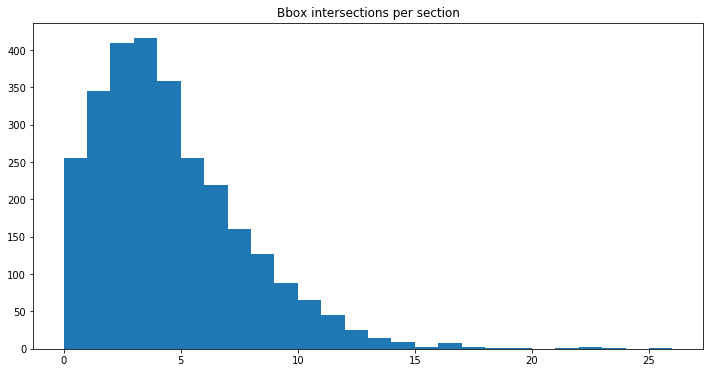

In [73]:
f, ax = plt.subplots(1, 1, figsize=(12,6))
ax.hist(intersections.values(), bins=max(intersections.values()));
ax.set_title('Bbox intersections per section');

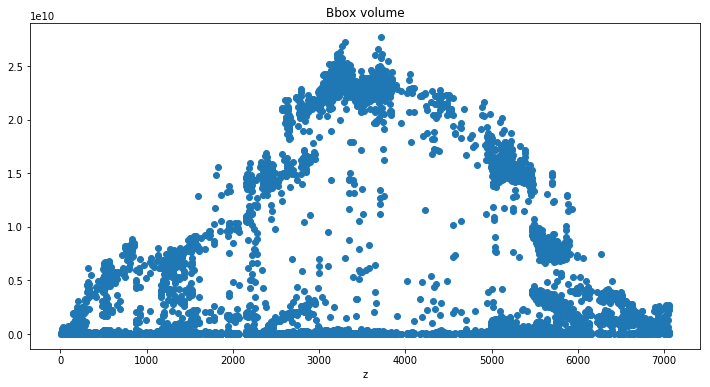

In [75]:
x = [z for z, v in sections.items() for k in v]
y = [k.volume() for z, v in sections.items() for k in v]
f, ax = plt.subplots(1, 1, figsize=(12,6))
ax.scatter(x, y);
ax.set_xlabel('z')
ax.set_title('Bbox volume');